# 03_Modelado — Comparación de clasificadores (regresión logística, árbol y random forest)

# Importación de librerías

In [1]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as SKPipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.metrics import (
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)

# Lectura del dataset

In [2]:
df = pd.read_csv('../data/diabetes_dataset.csv')
df.head()

,age,gender,ethnicity,education_level,income_level,employment_status,smoking_status,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,...,hdl_cholesterol,ldl_cholesterol,triglycerides,glucose_fasting,glucose_postprandial,insulin_level,hba1c,diabetes_risk_score,diabetes_stage,diagnosed_diabetes
0,58,Male,Asian,Highschool,Lower-Middle,Employed,Never,0,215,5.7,...,41,160,145,136,236,6.36,8.18,29.6,Type 2,1
1,48,Female,White,Highschool,Middle,Employed,Former,1,143,6.7,...,55,50,30,93,150,2.00,5.63,23.0,No Diabetes,0
2,60,Male,Hispanic,Highschool,Middle,Unemployed,Never,1,57,6.4,...,66,99,36,118,195,5.07,7.51,44.7,Type 2,1
3,74,Female,Black,Highschool,Low,Retired,Never,0,49,3.4,...,50,79,140,139,253,5.28,9.03,38.2,Type 2,1
4,46,Male,White,Graduate,Middle,Retired,Never,1,109,7.2,...,52,125,160,137,184,12.74,7.20,23.5,Type 2,1


# Depuración de variables y definición de X y Y

In [3]:
cols_to_drop = ['diabetes_stage', 'cholesterol_total', 'glucose_postprandial']
df = df.drop(columns=cols_to_drop, errors='ignore')

target_col = 'diagnosed_diabetes'

if target_col not in df.columns:
    raise ValueError(f"La columna objetivo '{target_col}' no existe en el dataframe.")

X = df.drop(columns=[target_col])
y = df[target_col].copy()

print("Shape de X:", X.shape)
print("Distribución de y:")
print(y.value_counts(normalize=True))

Shape de X: (100000, 27)
Distribución de y:
diagnosed_diabetes
1    0.59998
0    0.40002
Name: proportion, dtype: float64


# División en train y test

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("\nProporción en train:")
print(y_train.value_counts(normalize=True))
print("\nProporción en test:")
print(y_test.value_counts(normalize=True))

X_train: (80000, 27) X_test: (20000, 27)

Proporción en train:
diagnosed_diabetes
1    0.599975
0    0.400025
Name: proportion, dtype: float64

Proporción en test:
diagnosed_diabetes
1    0.6
0    0.4
Name: proportion, dtype: float64


# Identificación de tipos de variables

In [5]:
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

binary_cols = ['family_history_diabetes', 'hypertension_history', 'cardiovascular_history']

numeric_to_scale = [col for col in num_cols if col not in binary_cols]

print("Numéricas a escalar:", numeric_to_scale)
print("Binarias (sin escalar):", binary_cols)
print("Categóricas:", cat_cols)

Numéricas a escalar: ['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'glucose_fasting', 'insulin_level', 'hba1c', 'diabetes_risk_score']
Binarias (sin escalar): ['family_history_diabetes', 'hypertension_history', 'cardiovascular_history']
Categóricas: ['gender', 'ethnicity', 'education_level', 'income_level', 'employment_status', 'smoking_status']


# Transformaciones: escalado y one-hot encoding

In [6]:
numeric_transformer = SKPipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = SKPipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num_scaled', numeric_transformer, numeric_to_scale),
    ('num_binary', 'passthrough', binary_cols),
    ('cat', categorical_transformer, cat_cols)
])

# Definición de modelos base con balanceo (regresión logística, árbol y random forest)

In [7]:
logreg_clf = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)

tree_clf = DecisionTreeClassifier(
    class_weight='balanced',
    random_state=42
)

rf_clf = RandomForestClassifier(
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Construcción de pipelines por modelo

In [8]:
pipe_logreg = SKPipeline(steps=[
    ('preproc', preprocessor),
    ('clf', logreg_clf)
])

pipe_tree = SKPipeline(steps=[
    ('preproc', preprocessor),
    ('clf', tree_clf)
])

pipe_rf = SKPipeline(steps=[
    ('preproc', preprocessor),
    ('clf', rf_clf)
])

# Definición de espacio para hiperparámetros para para GridSearchCV

In [9]:
param_grid_logreg = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__solver': ['lbfgs', 'liblinear'],
    'clf__penalty': ['l2']  
}

param_grid_tree = {
    'clf__max_depth': [3, 5, 7, 9, None],
    'clf__min_samples_split': [2, 10, 20],
    'clf__min_samples_leaf': [1, 5, 10]
}

param_grid_rf = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [5, 10, None],
    'clf__min_samples_split': [2, 10],
    'clf__min_samples_leaf': [1, 5],
    'clf__max_features': ['sqrt', 'log2']
}

# Configuración de validación cruzada estratificada y métrica prioritaria

In [10]:
scorer_recall_pos = make_scorer(recall_score, pos_label=1)

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

# Lanzamiento de GridSearchCV para cada modelo

In [11]:
models = {
    'logreg': (pipe_logreg, param_grid_logreg),
    'tree': (pipe_tree, param_grid_tree),
    'rf': (pipe_rf, param_grid_rf)
}

grid_results = {}
best_estimators = {}

In [ ]:
for name, (pipe, param_grid) in models.items():
    print(f"\n🔹 Entrenando y buscando hiperparámetros para: {name}")
    
    gs = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring=scorer_recall_pos,   
        cv=cv,
        n_jobs=-1,
        verbose=1
    )
    
    gs.fit(X_train, y_train)
    
    print(f"Mejor recall (CV) para {name}: {gs.best_score_:.4f}")
    print("Mejores hiperparámetros:", gs.best_params_)
    
    grid_results[name] = gs
    best_estimators[name] = gs.best_estimator_


🔹 Entrenando y buscando hiperparámetros para: logreg
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Mejor recall (CV) para logreg: 0.8769
Mejores hiperparámetros: {'clf__C': 1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}

🔹 Entrenando y buscando hiperparámetros para: tree
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Mejor recall (CV) para tree: 0.8957
Mejores hiperparámetros: {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}

🔹 Entrenando y buscando hiperparámetros para: rf
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Mejor recall (CV) para rf: 0.8703
Mejores hiperparámetros: {'clf__max_depth': None, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}


# Resumen de recall e hiperparámetros

In [13]:
resumen_modelos = []

for name, gs in grid_results.items():
    resumen_modelos.append({
        'modelo': name,
        'mejor_recall_CV': gs.best_score_,
        'mejores_params': gs.best_params_
    })

resumen_df = pd.DataFrame(resumen_modelos)
resumen_df

,modelo,mejor_recall_CV,mejores_params
0,logreg,0.876870,"{'clf__C': 1, 'clf__penalty': 'l2', 'clf__solv..."
1,tree,0.895725,"{'clf__max_depth': None, 'clf__min_samples_lea..."
2,rf,0.870328,"{'clf__max_depth': None, 'clf__max_features': ..."


**Nota:** durante el proceso de modelado se entrenaron y compararon tres clasificadores distintos (regresión logística, árbol y random forest) utilizando validación cruzada estratificada y búsqueda de hiperparámetros mediante GridSearchCV. Para cada modelo se evaluó el desempeño en términos de recall, dado que esta métrica es prioritaria en un contexto donde es más costoso no identificar correctamente a los casos positivos.

En el caso de la regresión logística, se analizaron ocho combinaciones de hiperparámetros a lo largo de cinco particiones de validación cruzada, para un total de 40 modelos entrenados. El mejor desempeño alcanzó un recall promedio de 0.8769, con una configuración óptima que incluye un valor de regularización C = 1, penalización L2 y el solver lbfgs.

Para el árbol, la búsqueda fue más amplia, evaluando 45 combinaciones de parámetros y entrenando 225 modelos en total. Este clasificador obtuvo un recall promedio superior al de la regresión logística, alcanzando 0.8957. Los mejores hiperparámetros corresponden a un árbol sin límite de profundidad, con una mínima restricción en el número de muestras requeridas para dividir nodos o formar hojas.

En el caso del random forest, se evaluaron 48 configuraciones distintas, lo que implicó entrenar 240 modelos. Su mejor recall promedio fue de 0.8703, un valor menor al de los otros dos clasificadores. Los hiperparámetros óptimos incluyen un número moderado de 100 árboles, profundidad ilimitada, uso del criterio “log2” para seleccionar características en cada división y parámetros mínimos bajos para dividir nodos y formar hojas.

# Almacenamiento de los tres modelos de forma independiente

In [14]:
os.makedirs('../models', exist_ok=True)

for name, model in best_estimators.items():
    ruta = f"../models/modelo_{name}.joblib"
    joblib.dump(model, ruta)
    print(f"Modelo guardado: {ruta}")


Modelo guardado: ../models/modelo_logreg.joblib
Modelo guardado: ../models/modelo_tree.joblib
Modelo guardado: ../models/modelo_rf.joblib


# Comparación rápida de los modelos

In [15]:
def evaluar_modelo(nombre, modelo, X_test, y_test):
    y_pred = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, "predict_proba") else None
    
    print(f"\n===== {nombre} =====")
    print("Reporte de clasificación:")
    print(classification_report(y_test, y_pred, digits=4))
    
    if y_proba is not None:
        print("ROC AUC:", roc_auc_score(y_test, y_proba))
    
    print("Matriz de confusión:")
    print(confusion_matrix(y_test, y_pred))

In [16]:
for name, best_model in best_estimators.items():
    evaluar_modelo(name, best_model, X_test, y_test)


===== logreg =====
Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.8308    0.9025    0.8652      8000
           1     0.9310    0.8775    0.9035     12000

    accuracy                         0.8875     20000
   macro avg     0.8809    0.8900    0.8843     20000
weighted avg     0.8910    0.8875    0.8882     20000

ROC AUC: 0.9339465729166667
Matriz de confusión:
[[ 7220   780]
 [ 1470 10530]]

===== tree =====
Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.8368    0.8113    0.8238      8000
           1     0.8767    0.8945    0.8855     12000

    accuracy                         0.8612     20000
   macro avg     0.8567    0.8529    0.8547     20000
weighted avg     0.8607    0.8612    0.8608     20000

ROC AUC: 0.8528749999999999
Matriz de confusión:
[[ 6490  1510]
 [ 1266 10734]]

===== rf =====
Reporte de clasificación:
              precision    recall  f1-score   support


**Nota:** La comparación de modelos muestra que la regresión logística ofrece un desempeño sólido y equilibrado, con un accuracy de 0.8875 y un AUC de 0.93. Detecta correctamente la mayor parte de los casos, alcanzando un recall de 0.88 para la clase positiva y una precisión de 0.93, aunque aún presenta un número moderado de falsos negativos (1470). 

El árbol, en contraste, obtiene un rendimiento inferior, con un accuracy de 0.8612 y un AUC de 0.85. Aunque logra una buena sensibilidad para la clase positiva (recall de 0.89), presenta más errores globales, especialmente un mayor número de falsos positivos y falsos negativos, lo que limita su capacidad de generalización.

El random forest resulta ser el modelo más robusto y preciso. Con un accuracy de 0.9192 y un AUC de 0.94, supera claramente a los otros modelos. Su desempeño destaca por su capacidad para evitar falsos positivos (solo 26) y por mantener una precisión muy alta en ambas clases (superior al 0.99). Aunque su recall para la clase positiva es ligeramente menor que el de la regresión logística (0.8675), su equilibrio general entre precisión, sensibilidad y discriminación lo convierte en el mejor modelo por ahora. 

No obstante, es necesario evaluar la curva de aprendizaje de todos los modelos para verificar sí hay o no sobreajuste. Esto se despliega en el cuadernillo 04_Evaluación y comunicación. 

# Matrices de confusión graficadas

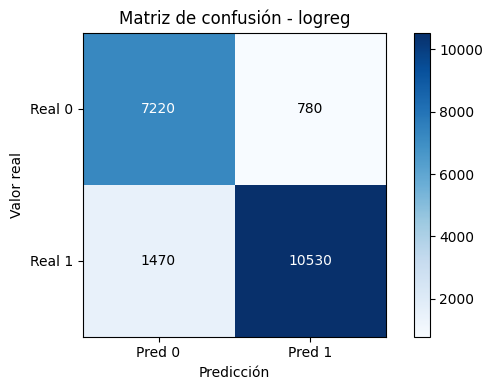

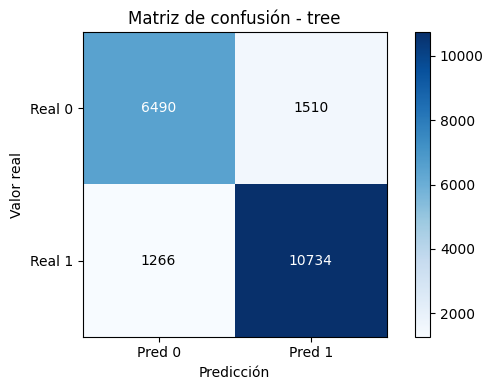

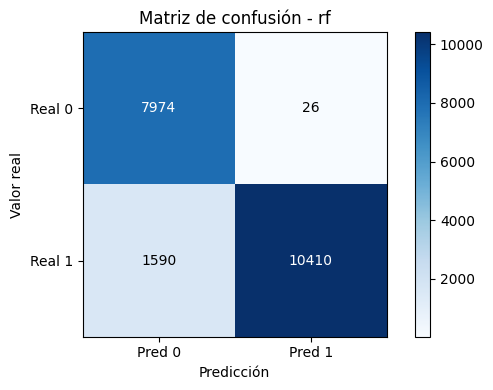

In [17]:
def graficar_confusion(nombre, modelo, X_test, y_test):
    y_pred = modelo.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6,4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"Matriz de confusión - {nombre}")
    plt.colorbar()

    clases_reales = ["Real 0", "Real 1"]
    clases_pred = ["Pred 0", "Pred 1"]
    tick_marks = np.arange(len(clases_reales))

    plt.xticks(tick_marks, clases_pred)
    plt.yticks(tick_marks, clases_reales)

    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel("Valor real")
    plt.xlabel("Predicción")
    plt.tight_layout()
    plt.show()

for name, best_model in best_estimators.items():
    graficar_confusion(name, best_model, X_test, y_test)